In [61]:
%matplotlib inline
import math
import torch 
from torch import nn
from torch.nn import functional as F 
from d2l import torch as d2l
from sklearn.model_selection import ParameterGrid

In [62]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01, plot_flag=True):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))
        
    def forward(self, inputs, state=None):
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                              device=inputs.device)
        outputs = []
        for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
            state = torch.tanh(torch.matmul(X, self.W_xh) +
                             torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state

In [66]:
#RNN implementaion with learnable embeddings rather than one-hot encoding 
class EmbRNNLMScratch(d2l.Classifier):
    """The RNN-based language model implemented from scratch."""
    def __init__(self,rnn,vocab_size,emb_len=8,plot_flag=True,lr=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens,self.emb_len) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.emb_len))
        self.lembs = nn.Parameter(torch.randn(self.vocab_size,self.emb_len))

    def forward(self,X,state=None): # X is the batch of token indices
        embs = torch.matmul(self.one_hot(X).float(),self.lembs) # we will get the embeddings by multiplying it with the embedding 
        rnn_outputs, _ = self.rnn(embs,state) #RNN forward pass discarding the final hidden state
        return self.output_layer(rnn_outputs) 

    def training_step(self,batch,plot_flag=True):
        print(batch[0].shape)
        l = self.loss(self(*batch[:-1]),batch[-1])
        if plot_flag:
            self.plot('ppl',torch.exp(l),train=True)
        return l

    def validation_step(self, batch, plot_flag=True):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if plot_flag:
            self.plot('ppl', torch.exp(l), train=False)
        return l

    def one_hot(self,X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T,self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H,self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs,1)

8.171242713928223

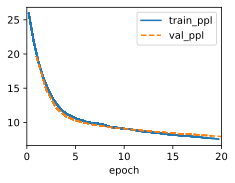

In [67]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
emb_len=len(data.vocab)
rnn = RNNScratch(num_inputs=emb_len, num_hiddens=32)
model = EmbRNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1, emb_len=emb_len)
trainer = d2l.Trainer(max_epochs=20, gradient_clip_val=1) 
trainer.fit(model, data)
X,y = next(iter(data.get_dataloader(False)))
y_hat = model(X) 
torch.exp(model.loss(y_hat,y)).item()

In [ ]:
# we can use sampling from a normalized probability distribution to get more creative text generation without repition 
class SampRNNLMScratch(RNNLMScratch):  #@save
    def predict(self, prefix, num_preds, vocab, device=None, alpha=1, sample=False):
        """Defined in :numref:`sec_rnn-scratch`"""
        state, outputs = None, [vocab.token_to_idx[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                if sample:
                    prob = F.softmax(Y[0],dim=-1) # we create probability distribution along the last dimension
                    prob = prob.pow(alpha) # we can change alphas value to control how deterministic the prediction is
                    # Normalize the probabilities
                    prob /= prob.sum(dim=-1).reshape(-1,1) # we reshape it to [batch_size,1] so that divison works
                    outputs.append(torch.multinomial(prob, num_samples=1))
                else:
                    outputs.append(torch.argmax(Y, axis=-1))
        return ''.join([vocab.idx_to_token[i] for i in outputs])
        

In [ ]:
: